## Содержание доклада:
1) Описание архитектуры YOLO\
2) Описание дата-сета, как собрал и разметил \
3) Обучение и результаты 

## YOLO - Архитектура нейросети для детектирования объектов на изображении
1)Очень быстра\
2)"Рассуждает" глобально\
3)Учит обобшаемые представления об объектах

<img src="YOLO.gif">

<img src="yolo_performance.png">

# Метрика mAP(mean AVARAGE PRECISION). 
Источник: blog.roboflow.com

CV сообщество сходится во мнении что mAP оптимальная метрика для сравнения эффективности object detection моделей.\
Задача object detection моделей сводится к определению присутствия конкретного объекта на изображении, его положения в кадре(bounding boxes), его класификации а также степень уверенности.\
<img src="blood_cells.gif">

Precision(точность) и Recal(полнота) базовые метрики для задач классификации 

Precision - мера того насколько точна модель там где она произвела классификацию. \
\
Recal - мера того сколько экземпляров конкретного класса были kлассифицированы как экземпляры этого класса. \
Например, модель которая находит только один экземпляр класса из десяти имеет идеальную точность, при полноте только 0.1 

В моделях в которых предусмотрен уровень уверенности, возможно найти компромисс между точностью и полнотой, регулируя граничное значение. \
Другими словами, если модель находится в ситуации, когда предотвращение ложных срабатываний более важно, чем предотвращение не срабатывания, граничное значение должно быть выше.

<img src="PR.png"  style="width: 800px;">
По мере снижения уверенности модели, кривая наклоняеется вниз. Если происходит что то другое значит с моделью что то не так))

\
\
Существует много способов свести PR кривую в одно значение \
F-мера - это гармоническое среднее точности и полноты. \
$$ F = 2\frac{P*R}{P+R} $$
\
AUC- area under the curve площадь под PR кривой\
\
AP-средневзвешенная по полноте точность.

<img src="PR-Curve.png">

AUC и AP характеризуют PR-кривую вцелом, но исследовательское сообщество отдает предпочтениее AP ввиду ее интерпретируемости.

# Измерение корректности детектирования через IoU(Intersection over Union)

Модели детектирования объектов как правило прогнозируют ограничивающую рамку(bounding boxes) и метку класса. \
\
<img src="BB.png"  style="width: 600px;">
\
На практике, прогнозируемые рамки ВСЕГДА будут отклоняться от тех которые мы создали при разметке данных.\
Очевидно что мы будем считать прогноз неверным если модель выдала нам неправильную метку класса. \
Но что делать в случае со смещением рамок?\
\
<img src="BB1.png"  style="width: 600px;">
\
Intersection over Union (IoU) - площать пересечения прогнозируемого с истинным боксом деленная на обшую площадь обоих боксов. \
IoU - может служить пороговым значением для отсечения неуверенных прогнозов. Например, меньше 60% или 75%... \
\
<img src="iou.png"  style="width: 600px;">
\
<img src="iou1.jpeg"  style="width: 600px;">

# Вычисление mPA

Для того что бы вычислить mAP, нарисуем несколько PR-кривых ислользуя различное пороговое значение IoU. \
Красная PR-кривая нарисованна с максимальным пороговым значением IoU(допустим 90%)\
Оранжевая PR-кривая нарисованна с минимальным пороговым значением IoU(10%)\
Часто используются значения IoU от 0,5 до 0,95 с шагом 0,05 (COCO challenge) \
<img src="mAP.png"  style="width: 400px;">
\
Что быполучить mАР нужно усреднить АР для кадого значения IoU

# Архитектура современной object-detection модели 

<img src="Ob_Det.png"  style="width: 1000px;">

Архитектура EfficientNet \
\
<img src="OD.png"  style="width: 1000px;">

Архитектура YOLOv5 \
<img src="yolo_arc.png"  style="width: 1200px;">

# YOLO

С момента публикации первой модельт YOLOv1 в 2015 году было выпущено еще 4 поколения. Первые 4 из них сделаны на кастомном фреимворке Darknet, YOLOv5 собрана на PyThorh други автором, архитектурно не очень отличается от YOLOv4. 

### Концепт YOLO
Ключевая идея YOLOv1 это разделение изображения на ячейки с помощью сетки SxS(7х7 по умолчанию). Если центр какого то объекта попадает в ячейку то она становится ответственной за данный объект. Другими словами мы присваиваем этот объект этой ячейке. \
<img src="yolo1.jpeg"  style="width: 600px;">

Для каждой из 49 ячеек решается задача классификации и локализации.\
Для каждой ячейки прогнозируется B боксов и оценка уверенности. Эта оценка говорит о присутствии либо отсутствии объекта в данном боксе. \
$$ confidence score = p(Object)*IOU $$

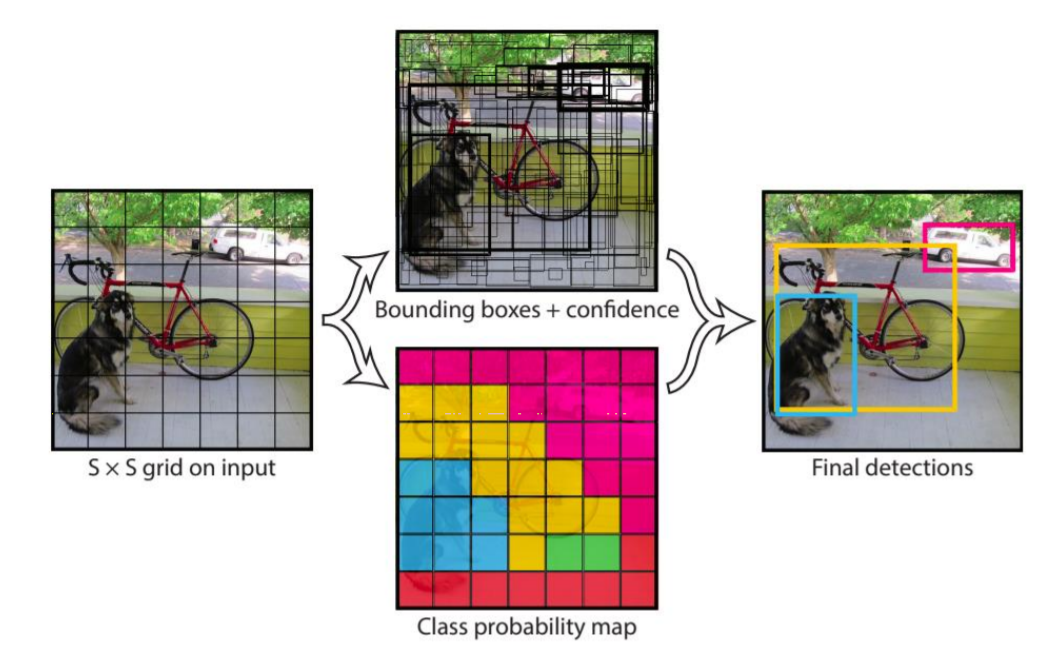

<img src="yolo2.jpeg"  style="width: 900px;">

Каждый бокс характеризуется 4 параметрами(x, y, h, w) где x,y - координаты центра, h и w - высота и ширина. Учитывая оценку уверенности получится 5 параметров) \
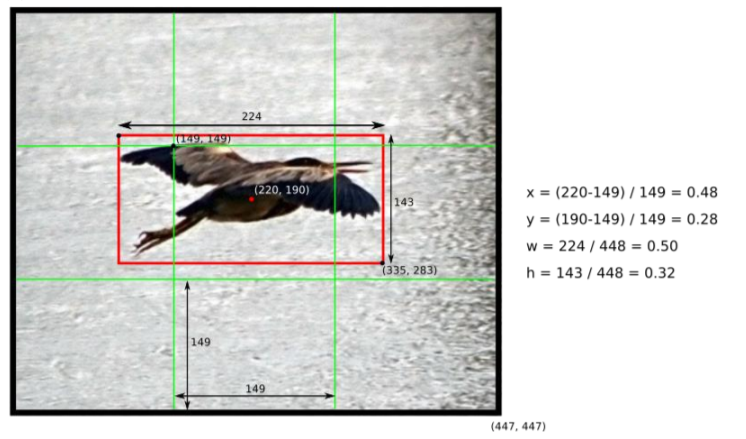

Таким образом, мы имеем 49 ячеек, в каждой по В( по умолчанию 2) бокса \
Если модель убучена на 20 классов, то для каждой ячейки модель будет формировать 20 значений вероятности для каждого класса. 

<img src="class_probs.png"  style="width: 400px;">

В таком случае прогноз модели будет закодирован как SxSx(B*5 + Кол.Классов) тензор. \
Для S = 7, Кол.классов=20 и B = 2 мы получим 7x7x30 тензор \
<img src="output_shape.png"  style="width: 600px;"> \
<img src="output_tenz.png"  style="width: 600px;">

### Архитектура YOLOv1

YOLO применяет сверточную нейронную сеть для синхронного прогнозирования множества боксов и вероятностей классов. \
Разработчики взяли за основу моделью GoogleNet для классификации изображений. \
YOLOv1 состоит из 24 сверточных слоев и двух полносвязных для прогнозирования боксов.\
Авторы оценивали работоспособность модели на датасете Pascal VOC, они использовали S=7, B=2 и С=20 \
На финальном слойе применяется линейная функция активации, на остальных leaky ReLU: $ f(x) = \begin{cases}x & x > 0\\0.1x & x<0\end{cases} $ \
Архитектура YOLO:

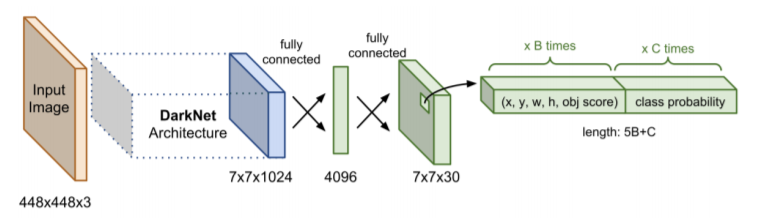

Архитектура GoogleNet:\
<img src="googleNet.png"  style="width: 600px;">

### Функция потерь
В качестве функции потерь применяется сумма квадратов ошибки для каждого объекта в каждой ячейке.\
Такую функцию потерь легко оптимизировать, однако она не совсем точно соответствует поставленной задаче максимизации средней точности(АР). \
Ошибка локализации взвешивается в равной степни с ошибкой классификации, которая может быть не идеальна.\
Кроме того, многие яейки могут вообще не содержать объектов, что приведет к тому что показатель "уверенности" будет стремиться к нулю и перекрывать градиент ячеек содержащих объекты. \
Это может привести к нестабильности модели и расхождении на ранних этапах обучения. \
Для борьбы с этим потери от прогноза координат бокса искуственно увеличены, а потери от прогноза уверенности в ячейках где нет объектов уменьшенны. \
Это сделано с помощью двух параметров $\lambda_{coord}=5 $ и $ \lambda_{noobj}=0.5  $ \
Так же, такая функция потерь одинаково учитывает потнри для маленьких и больших боксов, в то время как метрика ошибки должна отражать что маленькое отклонение в большом боксе не так критично как в маленьком.\
Эта проблема частично решается прогнозированием корня от h и w вместо h и w. 

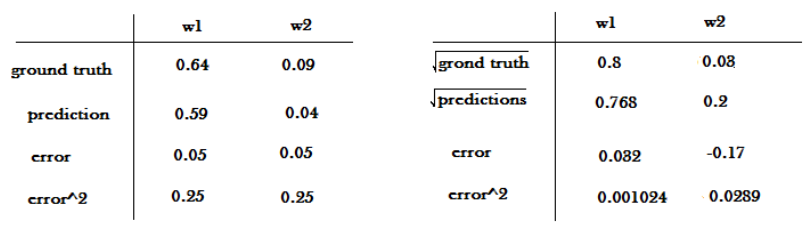
\
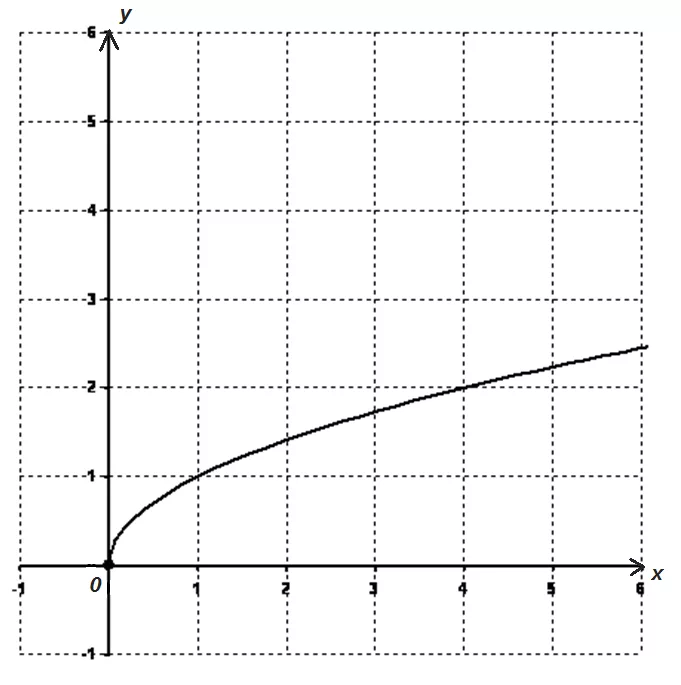
\
YOLO прогнозирует несколько боксов на ячейку. Во время обучения мы стремимся что бы за каждый объект был "ответственен" один прогнозируемый бокс. \
Он задается исходя их текущего максимального IOU. \
Функция потерь: \
$$ L = \lambda_{coord}\sum_{i=1}^{S^{2}}\sum_{j=1}^{B}\bf 1_{ij}^{obj}
 \left[\left(x_{i}-\overbrace{x_{i}}\right)^{2}+\left(y_{i}-\overbrace{y_{i}}\right)^{2}\right] $$
$$ +\lambda_{coord}\sum_{i=1}^{S^{2}}\sum_{j=1}^{B}\bf 1_{ij}^{obj}
 \left[\left(\sqrt{w_{i}}-\sqrt{\overbrace{w_{i}}}\right)^{2}+\left(\sqrt{h_{i}}-\sqrt{\overbrace{h_{i}}}\right)^{2}\right] $$
 $$ +\sum_{i=1}^{S^{2}}\sum_{j=1}^{B}\bf 1_{ij}^{obj}\left(C_{i}-\overbrace{C_{i}}\right)^{2} $$
 $$  +\lambda_{noobj}\sum_{i=1}^{S^{2}}\sum_{j=1}^{B}\bf 1_{ij}^{noobj}\left(C_{i}-\overbrace{C_{i}}\right)^{2} $$
 $$  + \sum_{i=1}^{S^{2}}\bf 1_{i}^{obj}\sum_{c\in classes}^{}\left(p(c)_{i}-\overbrace{p_{i}}(c)\right)^{2} $$

где $ \bf 1_{i}^{obj} $ обозначает что объект присутствует в ячейке i, $ \bf 1_{ij}^{obj} $ обозначает что jй предиктор в iй ячейке "ответственнен" за этот объект. \
Первые два слагаемых отвечают за положение бокса и его габариты. \
третье слагаемое отвечает за оценку уверенности. \
в четвертом слагаемом множитель $ \bf 1_{ij}^{noobj} $ равен 1 если ячейка не содержит объекта, или если jй бокс не ответственнен за данный объект, иначе 0. \
последний множитель отвечает за ошибку класса во всех ячейках.

Стоит упомянуть что функция потерь наказывает только ошибку в классификации в случае если объект присутствует в этой ячейке. \
Так же наказывается ошибка в координатах только в том случае если если этот предиктор ответственнен за этот объект.

### Не максимальное подавление
Так как в YOLO применяется сетка ячеек 7х7, то один объект может занимать больше одной ячейки и следовательно быть детектирован несколькими боксами. \
Необходимо что бы один объект был детекторован одним боксом)) \
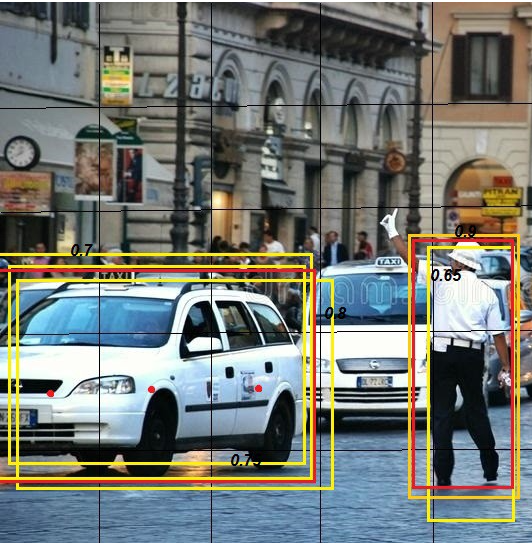

Например на изображении выше видно что такси может быть захвачено более трямя разными боксами(красная рамка это разметка). \
Эта проблемма решается следующим образом: 
1) отбросить все боксы со значением уверенности ниже какого то порогового значения(например 50%). \
2) отсортировать прогнозы по убыванию уверенности. \
3) выбрать бокс с максимальной уверенносоотью \
4) отбросить все боксы с большим IOU относительно бокса из предыдушего пункта. \
5) вернуться в пункт 3 пока не будут проверенны все оставшиеся боксы 

### Обучение:
Разработчики предварительно обучили сверточные слои извлечению признаков через классификации изображений на наборе данных с соревнований ImageNet 1000. \
Для предварительного обучения они использовали первые 20 сверточных слоев, за которыми следовали Average pooling и полносвяззный слой 1x1000 с размером входных данных 224 × 224. \
Эта сеть достигла показателя точности(top-5) 88%. \
Затем они удалили полносвязный слой и добавили четыре сверточных и два полносвязных слоя со случайно инициализированными весами и увеличили входное разрешение сети с 224 × 224 до 448 × 448. \
После чего модель обучалась как детектор объектов

### Эволюция YOLO
На данный момент опубликованно 5 версий YOLO. Каждая версия была была улучшением предыдущей и интегрировала в себя последние достижения в CV.
Перед тем как перейти к 5 версии разберем осовные улучшения в 4 предыдуших версияй.

## YOLOv2
### Batch-нормализация
Batch-нормализация это очень популярная техника нормализации в deep learning. Она позволяет ускорить и стабилизировать глубокие нейросети с помошью стабилизации распределения входных слоев во время обучения.\
Цель данного подхода заключается в нормализации признаков на выходе каждого слоя после активации к среднему равному 0 и стандартному отклонению равному 1. \
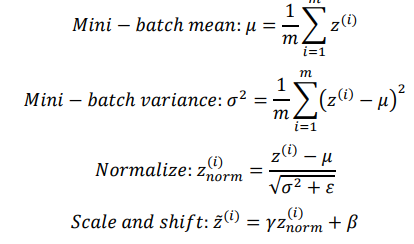 \
В YOLOv2 нормализация производится после всех сверточных слоев. Данная техгика не только уменьшает время затраченное на обучение но также увеличивает обобшаюшую способность сети, что позволяет увеличить mAP на 2%
### Классификатор высокого разрешения
В оригинальной версии YOLO первые 20 сверточных слоев обучались для извлечения признаков на изображения размерностью 224х224, затем были добавлены еще 4 сверточныхи два полносвязных слоя. После чего размерность была увеличина до 448х448 и начиналась стадия обучения детектирования объектов. \
При обучении второй версии после изменения размерности модель обучалась извлечению признаков на ImageNet еще 10 эпох перед тем как перейти к стадии обучения детектированию. \
Данный подход позволил увеличить mAP на 4%
### Anchor boxes(якорные боксы)
YOLO первой версии пытается назначить объект ячейке в которой находится центр этого объекта. \
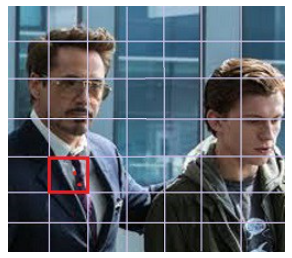 \
Таким образом, красная ячейка выше должна захватить два объекта: Тони Старк и его галстук. Но одна ячейка может захватить только один обект, и это проблемма. \
Для решения которой авторы попытались позволить модели детектировать больше одного объекта использую k боксов. \
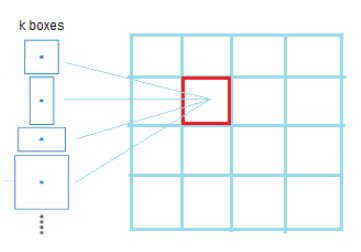 

YOLOv1 прогнозирует координаты бокса используя полносвязные слои после извлечения признаков сверточными. \
Во второй версии вместо этого применяется другая модель Faster R-CNN для прогнозирования боксов на основе якорных боксов(Anchor box). \
Anchor box - это два параметра w и h. Мы можем прогнозировать бокс относительно бокса вместо того что бы делать это относительно всей картинки. \
Используя эту идею легче обучать нейросеть. Используя только сверточные слои Faster R-CNN прогнозирует смещение и уверенность для anchor box



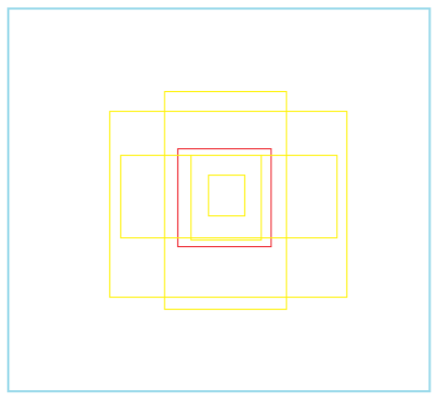 \
Вместо того что бы в ручную задавать якорные боксы, разработчики применила алгоритм k-средних для кластеризации всех боксов из обучающей выборки для всех классов. \
Для кластеризации использовали не Евклидово пространство а метрику IOU мезду боксом и центройдом(средним боксов в кластере). \
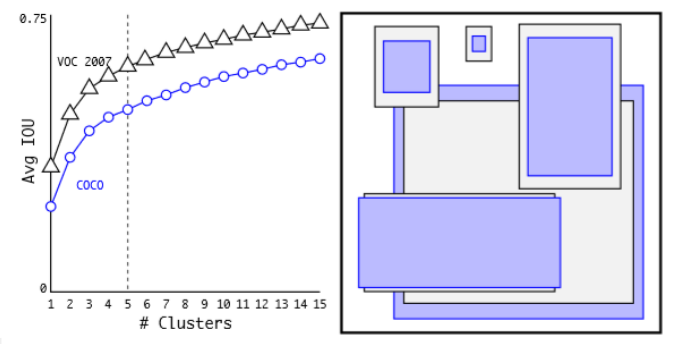 \
Авторы экспериментировали с двумя датасетами COCO и Pascal с различным количеством кластеров и остановились на k=5 как компромис между точностью и производительностью. \
На правой картинке изображены центройды то есть средневзвешенные боксы. \


YOLOv1 не ограничена в прогнозе позиции бокса. Параметры инициализируются рандомно и бокс может оказаться где угодно. \
В YOLOv2 каждая ячейка имеет внутри себя систему координат: c началом(0,0) в верхнем левом углу, правый нижний угол имеет координаты (1,1) \
Применяется сигмоида для того что бы ограничить координаты центра прогнозируемого бокса внутри ячейки. \
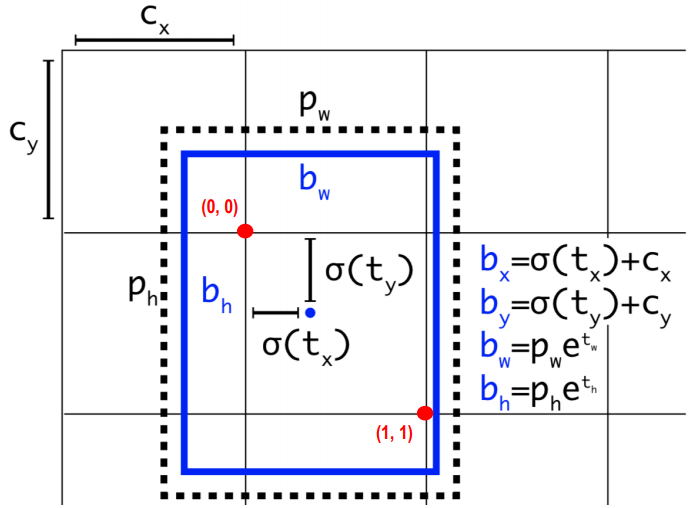 

Координаты центра бокса задаются с помощью сигмоиды и не могут выходить за пределы ячейки. Высота и ширина бокса задается относитель Anchor бокса. Выбирается тот Anchor ккоторый имеет наибольший IOU с разметкой. \
Поскольку модель ограничивает прогнозное местоположение, ее легче обучать, что делает сеть более стабильной. YOLOv2 c Anchor боксами улучшила mAP почти на 5%. 

### Архитектура YOLOv2

В качестве основы авторы применили новую модель классификации Darknet-19. Darknet-19 состоит из 19 сверточных 5 max-pooling слоев. Точность классификации (top-5) на ImageNet составила 91,2%. \
YOLOv2 выдает данные в формате 13х13х(k(1+4+20)), 20-количество классов. k-количество Anchor боксов. при k=5 получается тензор 13х13х125.

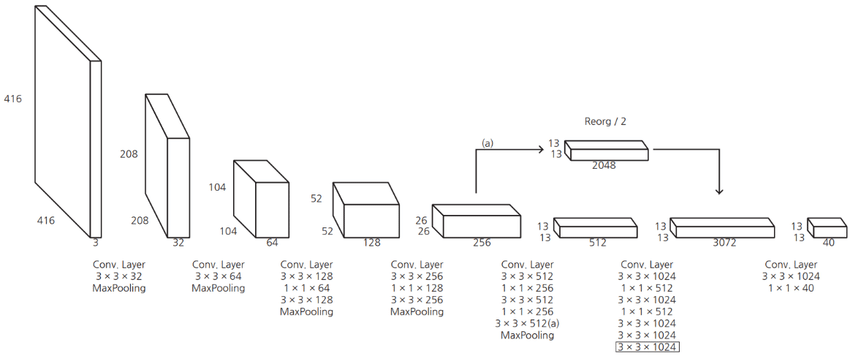

#### Обучение 
Модель оьучалась классификации, затем детектированию\
1) Классификация.Сеть Darknet-19 обучалась на датасете ImageNet 1000 на протяжении 160 эпох при размерности входного изображения 224х224. Затем входное изображение было изменено на 448х448 и проведено еще 10 эпох.\
точность top-1 достигла 76%, top-5 93% \
2) Затем последний сверточный слой и Darknet-19 был удален, а вместо него добавили три сверточных слоя с ядром 3х3 и один 1х1 с количеством выходов необходимых для детектирования 13х13х125. \
Также добавили сквозное соединение что бы модель могла использовать мелкие признаки с предыдуших слоев. \
Модель обучалась детекции 160 эпох на датасетах СОСО и VOC  

# YOLO 3
Вторая версия использует глубокую сверточную 30 слойную DakrNet архитектуру, это больше чем YOLOv1 на 11 слоев.\
Как правило в глубоких нейронных сетях чем больше слоев тем больше точность. \
Однако в глубоких слоях теряются мелкие признаки. ResNet предлагает пропускать соединения что бы помочь обратному распространинию через глубокие слои без затухания градиента. \
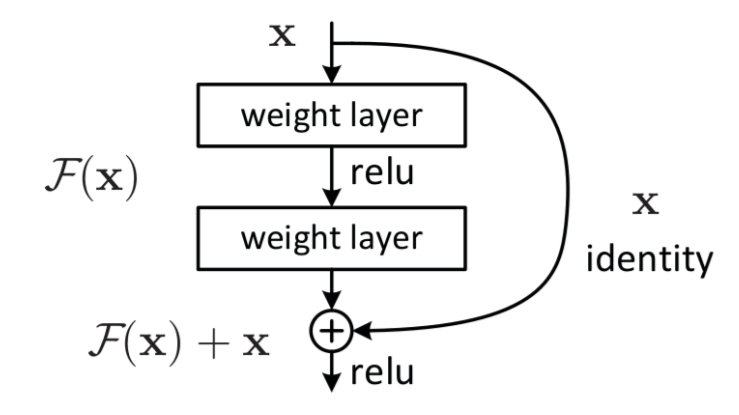 \
Для YOLOv3 была разработана архитектура в которой feature extractor использует гибрид YOLOv2и ResNet:DarkNet-53 \
Сеть построена с применением bottleneck structure(1х1 и 3х3 сверточные слои) внутри каждого residual block а так же сквозные соединения. \
Благодаря вставкам residual block'ов из ResNet дополнительные слои не приводят к снижению качества модели. \
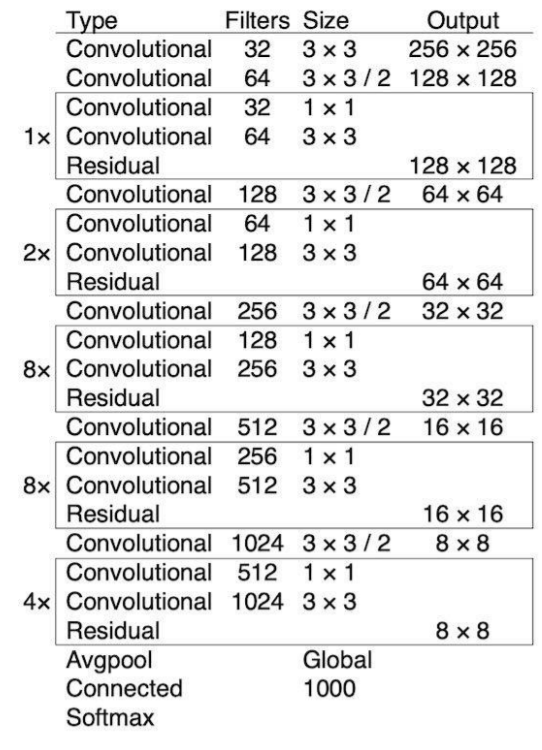 \
В модели применяется DarkNet-53(53 слоя) как экстрактор признаков, так же 53 слоя для детектирования, итого 106 слоев.

## Multi-scale detector (детектирование в несколькихмаштабах)

В двух предыдуших версиях YOLO входное изображение последовательно проходила через слои извлекоющие признаки(feature detector), затем на последних слоях прогнозирование положнения обьектов.\
В третьей версии разработчики производят детектирование после каждого из трех последних Residual блоков. \
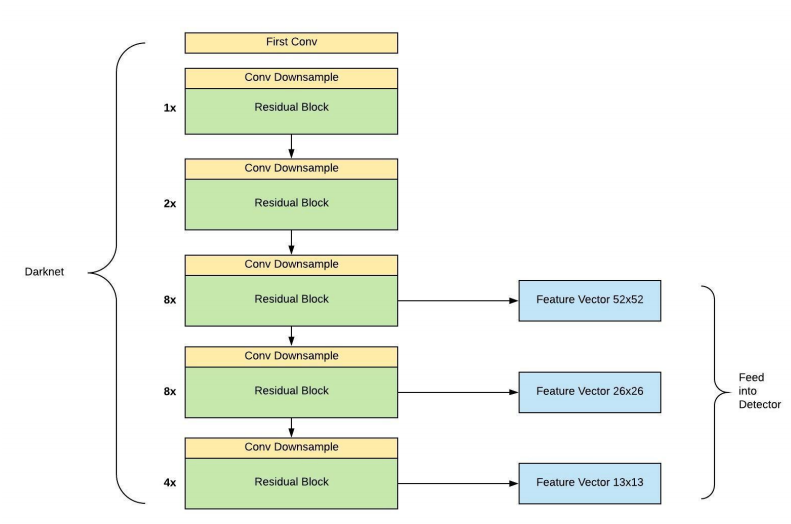 \
Детектирование происходит на 82м, 94м т 106 слое, что соответствует отношению с которым было сжато исходное изображение 32,16 и 8 соответственно.


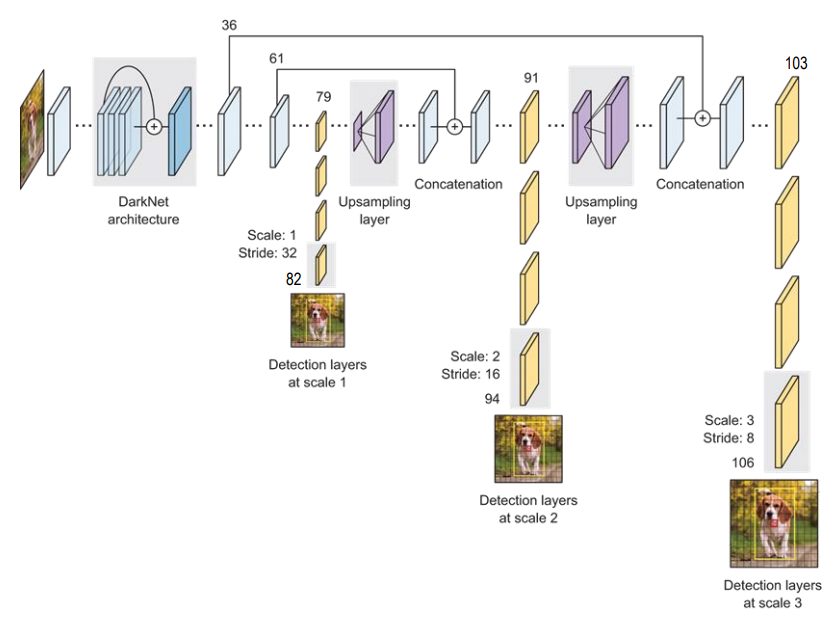

В отличии от YOLOv1 где боксы прогнозируются ячейкой имеющей набор прогнозов вероятностей классов, делаюших ячейку ответственной за прогноз только одного объекта, идея наделить ячейку возможностью прогнозировать несколько объектов одновременно была инициализированна в YOLOv2. Теперь боксы ответственны за детектирование объектов, а не ячейки\
Таким образом, каждый бокс имеет свой собственные набор вероятностей классов "С". \
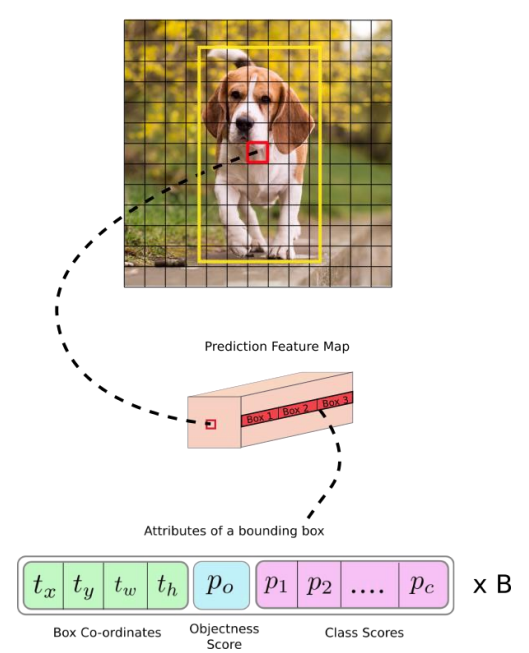

Первая стадия детектирования производится на 82м слое .\
По умолчанию, размерность входного изображения 416х416, после прохождения первых 81го слоя изображение сжато в 32 раза, как результат карта признаков имеет размер 13х13. На каждом слое детектирования применяется 1х1, которое отвечает за прогнозирование k боксов для каждой ячейки карты признаков. Yolov3 обучалась на датасете СОСО с k=3(B=3 бокса на ячейку) и С=80(80 классов)\
Таким образом, размерность ядра: 1х1х(3х(5х80)) = 1х1х255, на первом уровне детектирования финальная карта признаков имеет размерность 13х13х255.
Эта процедура детектирования повторяется еще два раза. Но перед этим карта признаков с 79 слоя апсэмплится в два раза и склеивается(конкатенируется) со картой с 61го слоя. \
Этот метод позволяет учесть как значимую симантическую информацию из апсемплинных признаков так и мелкие признаки из раннего слоя, затем еще 3 сверточных слоя и получается похожий тензор но в 2 раза больше 26х26х255. \
Затем это повторяется еще один раз на этот раз после 91го слоя карта апсемплится еще раз и склеивается с картой с 36го слоя. Получаем тензор 52х52х255.\
Итого, данная модель хорошо работает с большими и маленькими объектами. А не только с большими как например YOLOv2.

# YOLOv4

Оригинальный алгоритм YOLO был написан  Joseph Redmon, кто так же является автором кастомного фреймворка DarkNet.После 5 лет исследований и разработки 3го поколения YOLO, Джозеф ушел из CV по этическим соображениям. Однако, он не был против что бы кто то продолжил его работу. \
В апреле 2020  Alexey Bochkovsky русский инженер и исследователь, который написал DarkNet и 3 версии YOLO (основываясь на теоритических выводах Joseph Redmon) совместно с другими разработчиками опубликовал YOLOv4.

За последние годы было разработанно достаточно много алгоритмов для детектирования объектов которые достигли существенных результатов.\
Сформировалось две концептуальные архитектуры: Одностадийное и Двухстадийное детектирование объектов. \
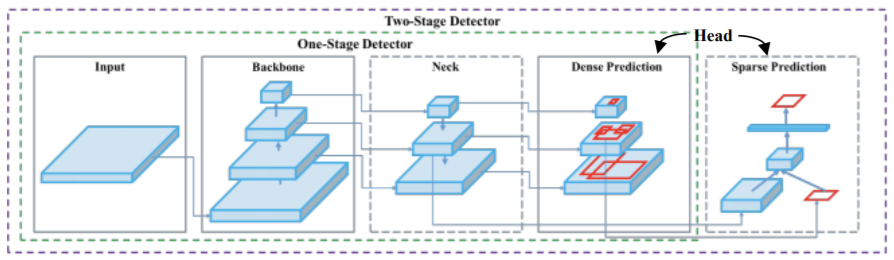 \
Входное изображение сжимается проходя через экстрактор признаков(BackBone), а затем отправляется в детектор объектов(Neck and Head)\
Neck работает как агрегатор признаков который перемешивает и комбинирует признаки сформированные в экстракторе для того что бы подготовить для детектора(Head)\
Разница двух концепций возникает здесь, на этапе Head, когда нужно принять решение относительно локацизации и классификации каждого бокса. \
Двухстадийные модели выполняют две эти задачи отдельно и комбинирую результат позже. \
Одностадийные модели делают это одновременно.\
YOLO это одностадийная модель(You Only Look Once).

Авторы провели серию экспериментов с наиболее продвинутыми и инновационными идеями в CV для каждой части архитектуры.\
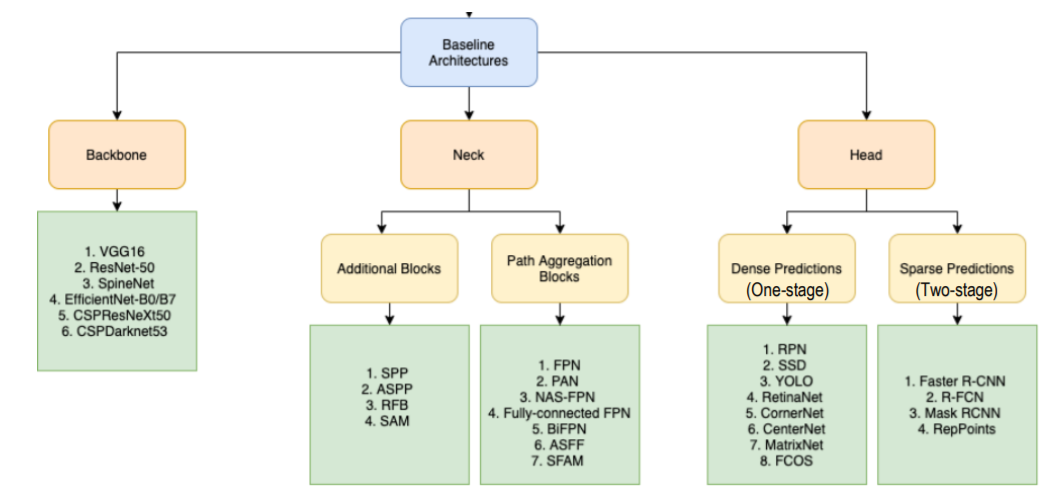

## Backbone(экстрактор признаков)
Для YOLOv4 рассматривалось 3 наиболее продвинутых сверточных сити на тот момент: CSPResNext53, CSPDarknet53 and EfficientNet-B3
CSPDarknet53 была выбрана как наиболее оптимальный вариант. \
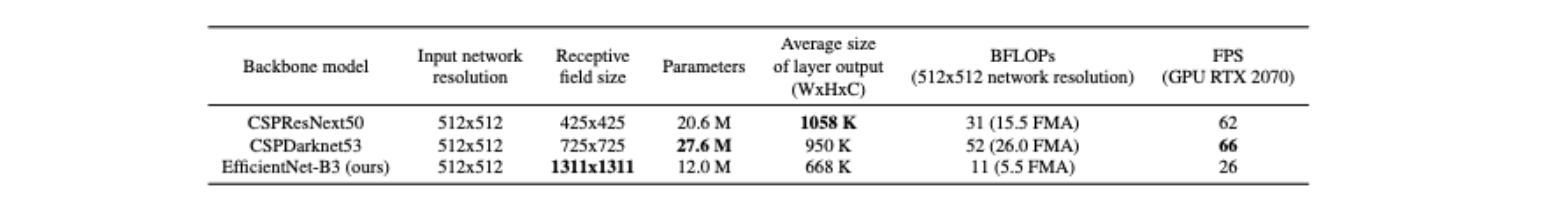

CSPResNext53 и CSPDarknet53(CSP - Cross Stage Partial) оба построены на основе архитектуры DenseNet, которая берет данные с предыдущего слоя  конкатенирует с данными текущего слоя. DenseNet была разработана таким образом что бы соединять напрямую очень глубокие слои с более ранними для борьбы с затуханием градиента(так же как ResNet)\
DenseNet c 3 Dence блоками:
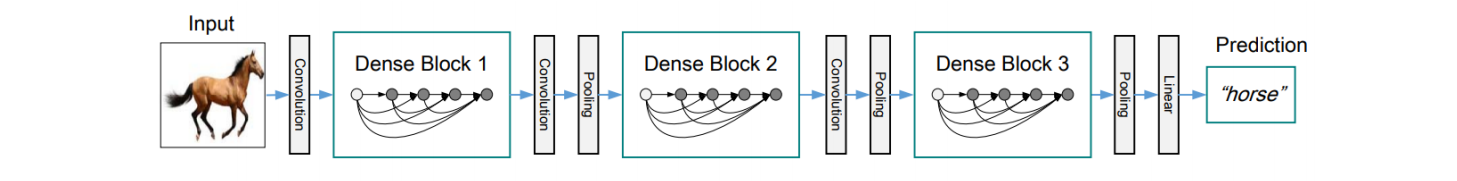

Каждая стадия DenseNet состоит из dense блока и транзитного уровня, каждый dense блок состоит из k dense слоев. \
Транзитный слой нужен для изменения размерности(downsample or upsample) c помощью свертки и пулинга.\
Результат iтого слоя будет склеин с его же входой информацией, таким образом формируя тензор на вход для слоя i+1/. \
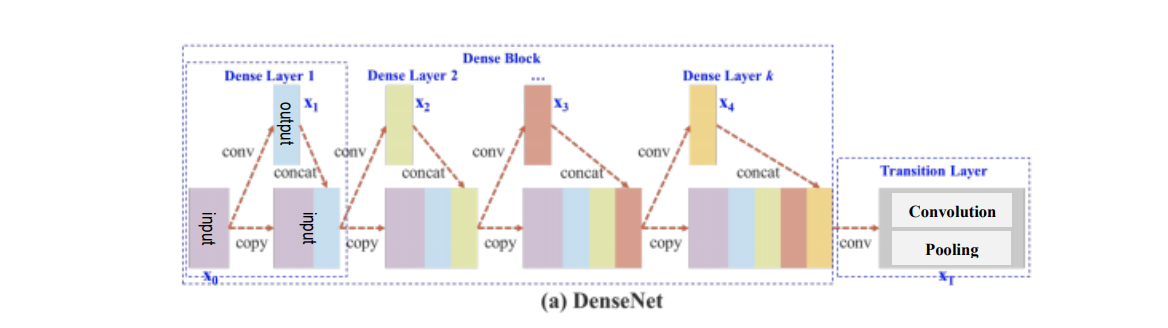

CSP (Cross Stage Partial) основанна на том же принципе что и DenseNet за исключением того что входная карта признаков разделяется на две части. Одна часть пропускается через dense блок, а вторая отправляется непосредственно на следуюший уровень без какой либо обработки.  \
В результате различные слои обрабатывают одну и туже информацию\ 
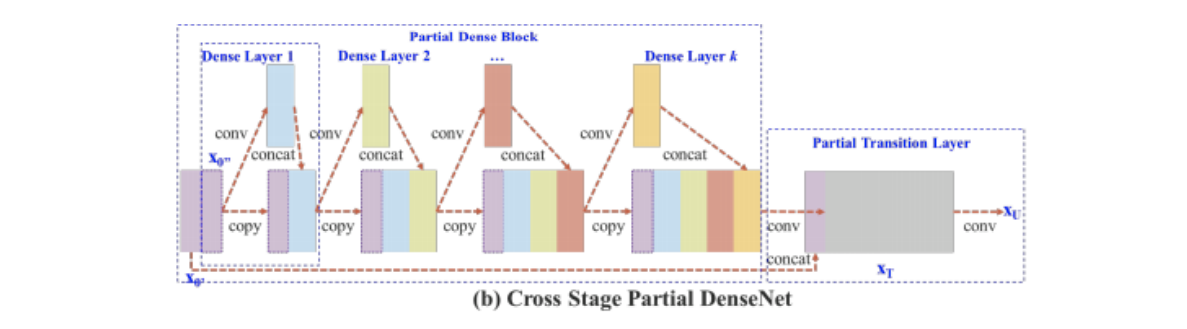

Комбинируя эти идеи с архитектурой Darknet-53 residual блоки заменены dense блоками.\
CSP сохраняет признаки на протяжении распространения, поощряя сеть к повторному использованию признаков там самым снижая количество параметров сети, помогает сохранять высокий уровень детализации признаков для более эффективной передачи их на  глубокии слои\
Так как чрезмерное увеличение dense слоев может привести к снижению скорости работы сети, только сверточный блок архетиктуры Darknet-53, который может извлекать наиболее семантически обогащенные признаки, выполнен в виде dense блока.\
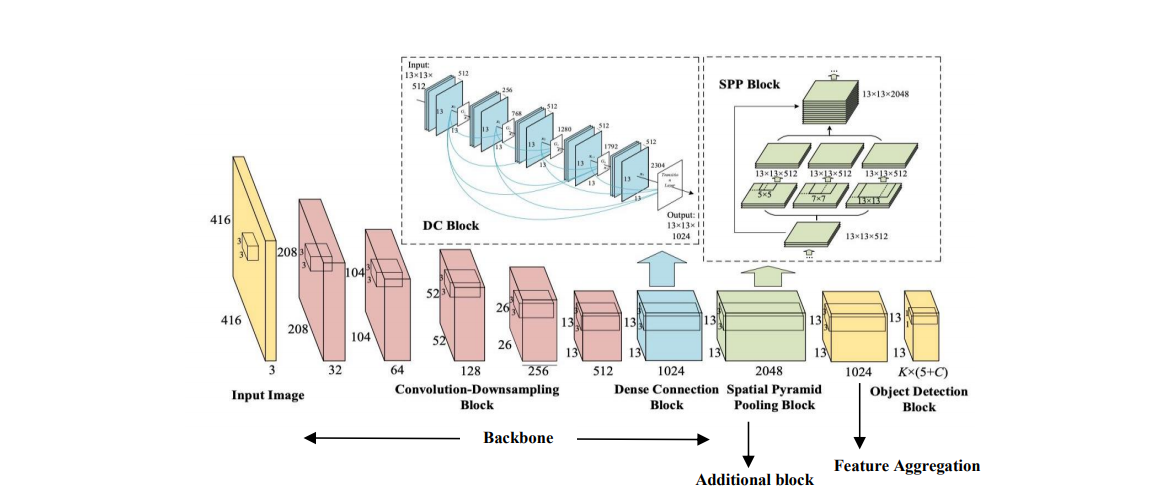

## Neck (аггрегатор признаков)
###  Additional block – SPP block
Перед тем как отправить карту признаков в агрегатор (Neck),после выхода из backbone CSPDarknet53 карта пропускается через дополнительный блок(Spatial Pyramid Pooling block) для того что бы выделить наиболее важные признаки. \
Много СNN-моделей содержат в себе полносвязные слои которые принимают на вход строго фиксированного размера изображения. \
SPP был разработан для генерации фиксированного размера выхода при любом размере входа. Но не только для этого, еще SPP помогает извлечь важные признаки посредством pooling'а мульти-масштабной версии карты.\
\
В данном примере входая карта дублируется 2 раза(n=3) затем каждая копия проходит через ьакс-пуллинг с различным ядром.
Таким образом SPP блок одновременно извлекает n различных типов важных признаков.\
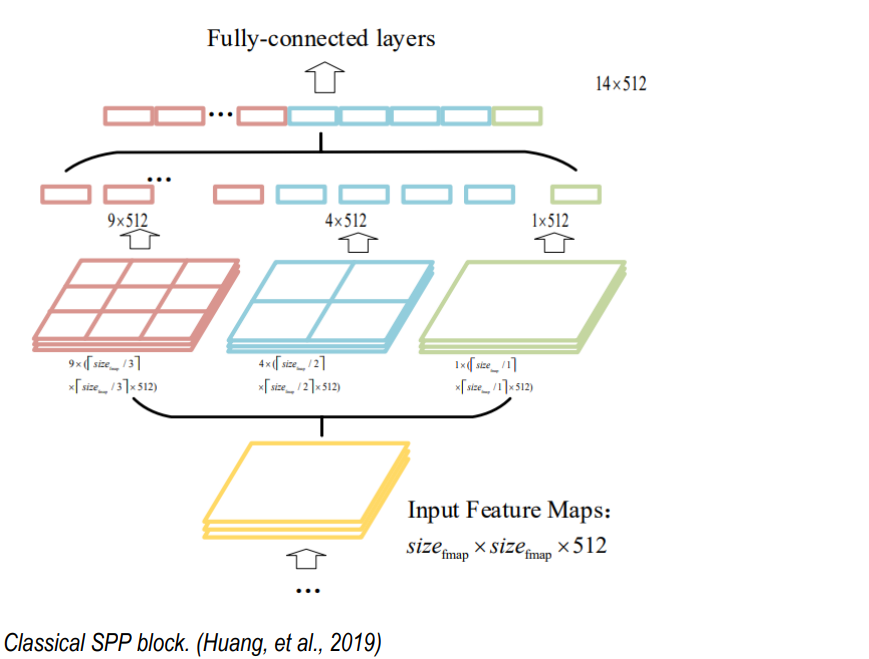

Так как полносвязные слои были исключены еще на стадии разработки второй версии YOLO, YOLO алгоритм применяет полносверточные слои которые позволяют принимать на вход входное изображение различного разрешения.\
Кроме того, YOLO производит прогнозирование положения боксов основываясь на SxS сетке нарисованной на изображении.\
Следовательно, конвертация двумерной карты в одномерный вектор не желательно.\
\
По этой причине SPP блок модифицирован для сохранения выходного масштаба. Новый SPP блок помещен после BACKBONE(экстрактор).\
Для снижения количества карт поступающих в SPP блок(с 1024 до 512), применяется 1х1 свертка между экстрактором и SPP.\
После этото карты копируются и пулятся так же как в классическом SPP блоке за исключеием того что применяется паддинг для сохранения исходного масштаба size x size x 512.\
После пуллинга три набора карт а так же входной набор карт конкатенируются, что позволяет избежать потери важных признаков, облегчить обучение а так же сохранить размерность.\
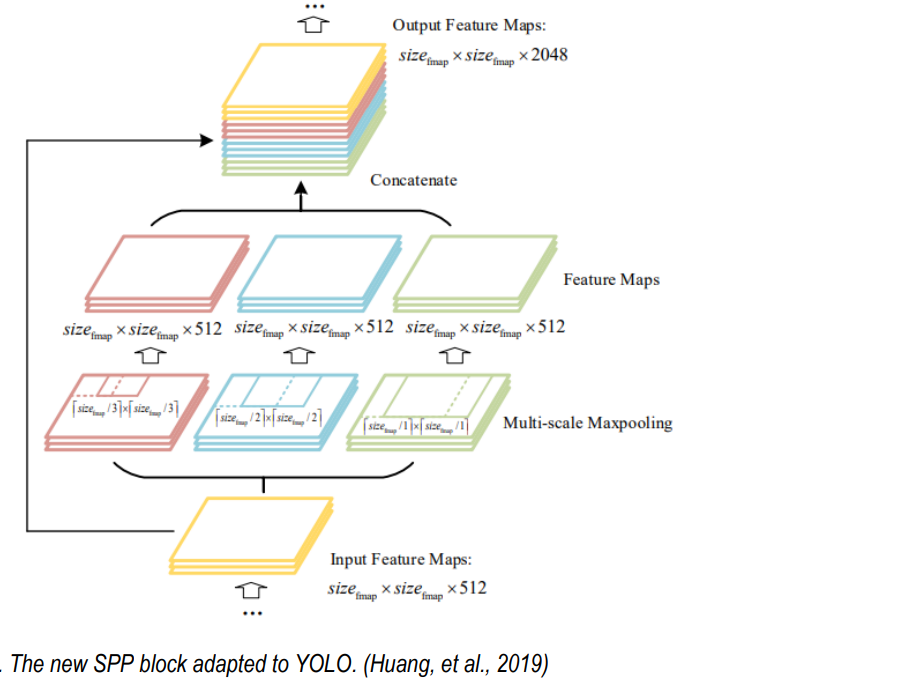




### Feature Aggregation – PANet Path Aggregation Network(аггрегатор признаков)
Взодное изображение проходя через backbone преобразуется в карту семантических признаков. Другими словами, при движении от низкоуровневых слоев к глубоким сложность симантических признаков увеличивается, а пространственное разрешение уменьшается. Это приводит к потере пространственной информации и мелких признаков. Для борьбы с этим явлением Joseph Redmon применил Feature Pyramid Network (FPN) архитектуру еще в YOLOv3. \
FPN подразумевает конкатенацию глубокоуровневых симантических карт с низкоуровневыми(с ранних слоев backbone) для прогнозирования мелких объектов на высоком разрешении. \
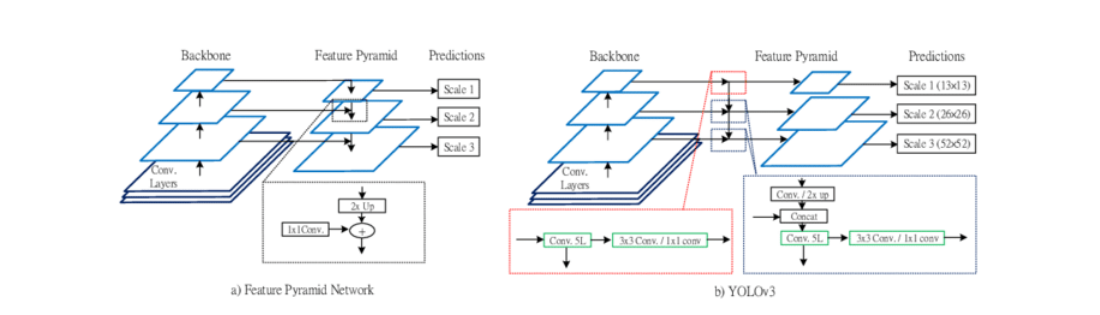

Path Aggregation Network (PAN) это улучшенная версия FPN.\
Так как течение информации в FPN происходит сверху-вниз, ТОЛЬКО низкий слой FPN(P2) способен одновременно уловить симантическую информацию с глубоких слоев и мелкие признаки с не глубоких слоев backbone. Т.Е. мелкомасштабный детектор улавает только симантическую инфрмацию из глубоких слоев при детектировании объектов./
Для того что бы улучшить работу мелко и средне масштабного детектора разработчики рассмотрели конкатенацию симантических признаков и мелких деталей на глубоких слоях сети.\

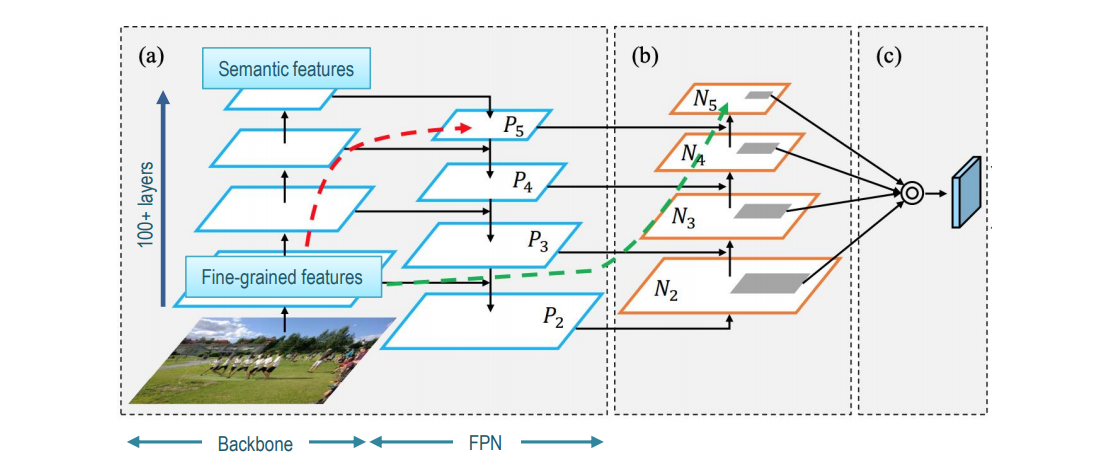

Современные экстракторы признаков(backbone) глубоких нейросетей могут состоять из более чем 100 слоев.\
Так мелким деталям признаков нужно проделать долгий путь(красный пунктир) что бы добраться до глубоких слоев.\
Авторы архитектуры восходящей PAN предлорили добавить короткий аугментационный путь паралельно структуре FPN, для того что бы напрямую соединить мелко детализированные признаки с глубокими слоями.\
Этот "короткий путь"(зеленый пунктир) состоит из менее чем 10 слоев и позволяет информации легко перетекать.
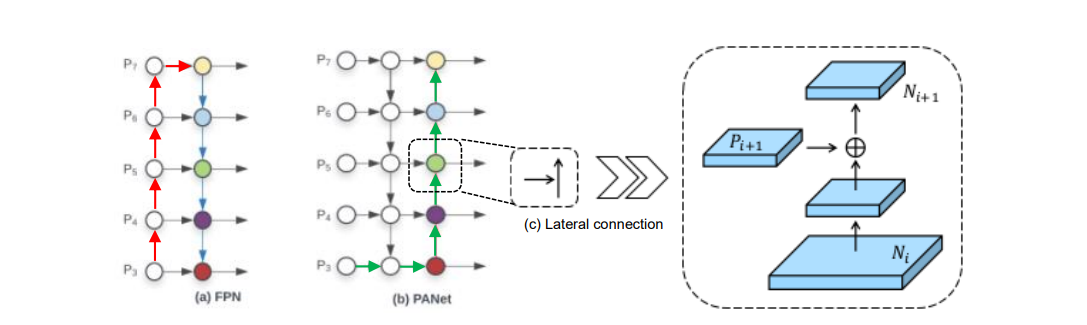

Структура PAN может быть рассмотренна как реплику низходящей структуры FPN, при чем каждый этап содержит слои которые производят карты признаков одинаковой размерности. В базовой архитектуре PAN эти слои горизонтально соединины с помошью поэлементного сложения, в модифицированной для YOLOv4 версии опкрация сложения заменена на операция конкатенации. Это помогает потоку информации не пропускать признаки ни с низходящего отока ни с восходящего.\
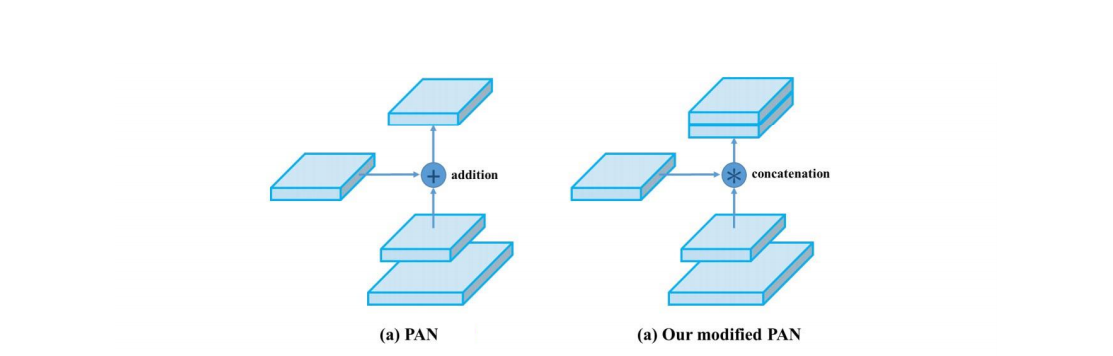



В FPN прогнозы в разных масштабах производились раздельно и не зависимо. Это приводило к дублированию прогнозов и отсутствию использования информации с других карт признаков.\
PAN совмещает все входные карты признаков восходящей пирамиды используя ROI(region of interest)\
Разворачивающий и полносвязный слои агрегируют всю вариативность признаков с карт всех уровней.
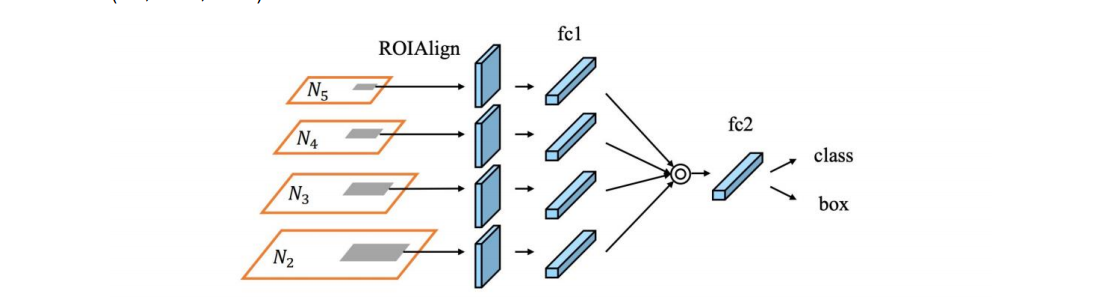

## Head – YOLOv3


Для одностадийных детекторов задача Head это прогнозирование положения и размера бокса, оценку уверенности и класс.\
YOLOv4 применяет ту же самую архитектуру Head что и YOLOv3 для детекции на основе anchor боксов на трех уровнях детализации.

# YOLOv5

Через месяц после публикации YOLOv4, исследователь и CEO компании Ultralystics Glenn Jocher опубликовал новую версию YOLO.\
Все предыдушие версии YOLO были разработаны на кастомном фреймворке Darknet, который написан преимущественно на С Алексеем Бочковским. 5 версия написана на одном из наиболее популярном в глубоком обучении фреймворке PyTorch.\
YOLOv5 так же как YOLOv4 основанна на последних инновационных разработках в CV, 5 и 4 версии очень похожи теоритически\
### Существенные отличия - Адаптивные anchor боксы
Автор YOLOv5 пока что не выпустил официольной статьи, только ведет репозиторий на Github.
Проаналировав файл  .yaml можно резюмировать архитектуру модели YOLOv5 следующим образом:
- Backbone: Focus structure, CSP network
- Neck: SPP block, PANet
- Head: YOLOv3 head using GIoU-loss
Joseph Redmon в YOLOv2 применял anchor боксы и процедуру для выбора ancor бокса размер и форма которого близка к одной из 5и груп боксов в датасете СОСО(80 классов). Это позволило увеличить точность и снизить время обучения.


Однако, когда мы применяем эти Anchor боксы к уникальному датасету(классы которого отличаются от 80 классов СОСО) эти боксы не могут быстро адаптироваться к разметке этого уникального датасета. Например при работе с датасетом состоящим из фотографий жирафа дефолтные anchor боксы не будут хорошо работать. Для решения этой проблеммы инженеру необходимо прогнать боксы из разметки жирафов через алгоритм кластеризации k-средних и перенести полученные параметры боксов в модель\
\
Glenn Jocher предложил интегрировать выбор anchor боксов в YOLOv5/
Как результат модель автоматически обучается для подбора лучших anchor боксов для конкретного датасета с которым она работает.

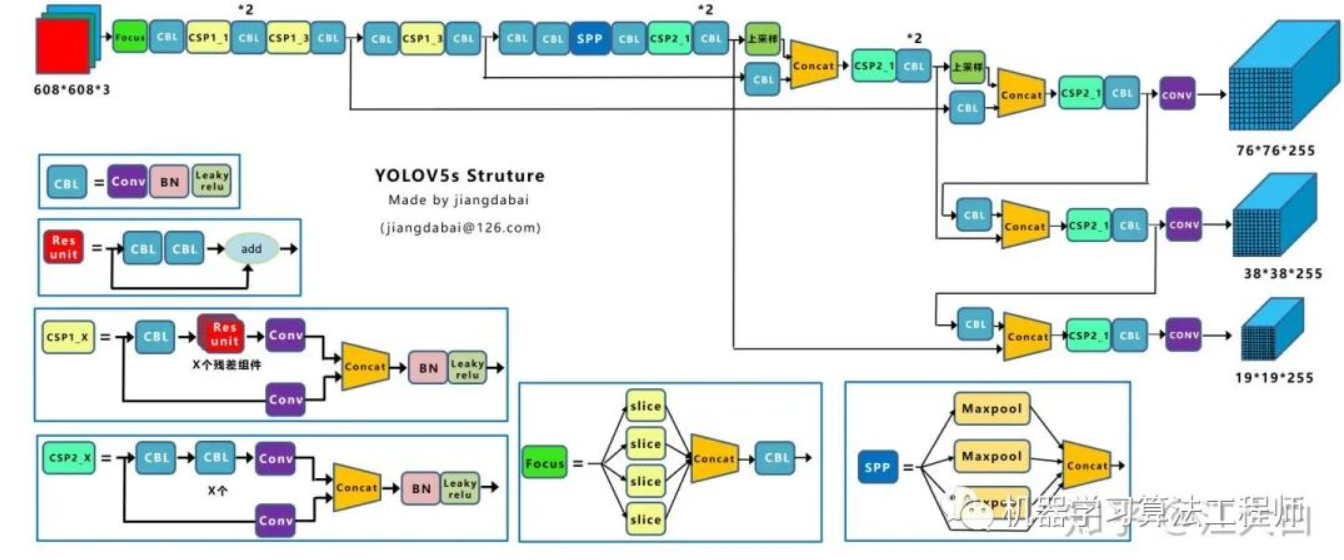

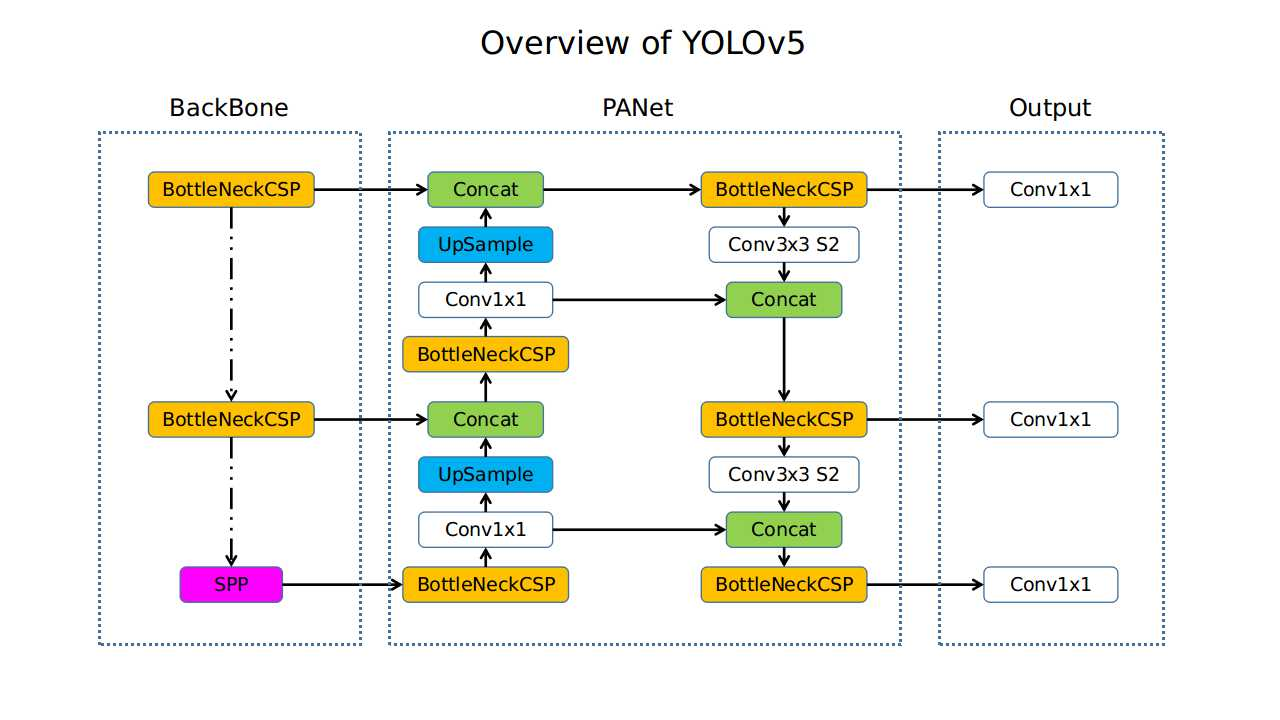

# ДАТАСЕТ

1) Парсим 10000 последних объявлений с сайта auto.ru \
2) Выбираем 200 самых популярных автомобилей \
3) Парсим панорамы 360 \
4) Раскладываем на кадры и делаем аугментацию(шум, отображение) 

In [1]:
import pandas as pd
import requests, json
import numpy as np
import urllib.request
import cv2

# ПАРСИНГ СПИСКА ХОДОВЫХ МОДЕЛЕЙ

In [3]:
headers = '''
Accept: */*
Accept-Encoding: gzip, deflate, br
Accept-Language: ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7
Connection: keep-alive
Content-Length: 92
content-type: application/json
Cookie: suid=0184da4362bac4a647c542eb4910ff1d.6d42fdeba0f71cfcf4e21f2b261a0467; _ym_uid=16173057381043722507; _ga=GA1.2.692984587.1617305753; _csrf_token=8c15524ed124bd00023a195d799610523ec45e9a8579017f; autoru_sid=a%3Ag60b685a72hfrq5sem2gc085kq3mbrl1.ee75698f33ae6fd0b6ebd295c1611b25%7C1622574503072.604800.TBNE5CtbwTBASSQRUJoG5Q.CjDVrPDRfx9zdMsKAurzmHORQZOrdAKZqvm5El85Wps; autoruuid=g60b685a72hfrq5sem2gc085kq3mbrl1.ee75698f33ae6fd0b6ebd295c1611b25; from=direct; yuidlt=1; yandexuid=9392325061609242005; my=YwA%3D; counter_ga_all7=2; crookie=35ef36BDYYW4Qacztf5/hsNbDK50yKxEg0flCTqpMwInfGmzMtS3Dy1a1AD5VwqORaT/aCxU1/3IbiF36xyEJBWdXiI=; cmtchd=MTYyMjU3NDUwOTA0OA==; gdpr=0; X-Vertis-DC=vla; _gid=GA1.2.579686948.1622653810; _ym_isad=2; gradius=100; gids=; cycada=+6gvrMi7eRapww0yG8BYIvBqch/UlIjHCeTIwb8Rdzk=; listing_view_session={%22sort%22:%22cr_date-desc%22}; listing_view=%7B%22version%22%3A1%7D; from_lifetime=1622654458600; _ym_d=1622654458
Host: auto.ru
Origin: https://auto.ru
Referer: https://auto.ru/cars/used/?seller_group=PRIVATE&sort=cr_date-desc&page=2
sec-ch-ua: " Not A;Brand";v="99", "Chromium";v="90", "Google Chrome";v="90"
sec-ch-ua-mobile: ?0
Sec-Fetch-Dest: empty
Sec-Fetch-Mode: same-origin
Sec-Fetch-Site: same-origin
User-Agent: Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36
x-client-app-version: 11f69dce6ee
x-client-date: 1622654468440
x-csrf-token: 8c15524ed124bd00023a195d799610523ec45e9a8579017f
x-page-request-id: b5a06e323d4441c7b67b1dd9ec41aedb
x-requested-with: fetch
'''.strip().split("\n")

url = "https://auto.ru/-/ajax/desktop/listing/"

dict_headers = {}
for header in headers:
    key, value = header.split(': ')
    dict_headers[key] = value

offers = []

for x in range(1, 270):
    param = {
        "category": "cars",
        "section": "used",
        "sort":"cr_date-desc",
        "page":x
    }
    
    response = requests.post(url, json=param, headers = dict_headers)
    data = response.json()
    offers.extend(data['offers'])

with open("data.json", "w", encoding="utf8") as f:
    json.dump(offers, f)

In [6]:
models= pd.DataFrame({'mark': ['VAZ'], 'model': ['1111'],'year_from':[1] ,'year_to':[2] ,'region':["mm"] })
mark=""
model=""
year_from = ""
year_to = ""
region = ""

with open("data.json", "r", encoding="utf8") as f:
    data = json.load(f)
print(len(data))

for offer in data:
    if offer['vehicle_info']['mark_info']['code']:
        mark=offer['vehicle_info']['mark_info']['code']
        model=offer['vehicle_info']['model_info']['code']
        year_from = offer['vehicle_info']['super_gen']['year_from']
        region = offer['seller']['location']['region_info']['name']
        try:
            year_to = offer['vehicle_info']['super_gen']['year_to']
        except:
            year_to ='по.н.в.'

        models = models.append({'mark': mark, \
                                'model': model, \
                                'year_from':year_from, \
                                'year_to':year_to, \
                                'region':region}, \
                                 ignore_index=True)

9953


In [35]:
df = models.groupby(['mark','model','year_from' ,'year_to' ],as_index = False).agg({
   'region':"count" 
}).sort_values('region', ascending=False).reset_index()
df['percent'] = 100*df['region']/9953

In [47]:
df.to_csv('most_popular_cars.csv')

In [ ]:
foto= pd.DataFrame({'class': [],'car': [],'mark': [], 'model': [],'year_from':[] ,'year_to':[] ,'pano_full':[] ,'pano_low':[] ,'pano_16x9_full':[] ,'pano_16x9_low':[]})
#num_ofers_pano= pd.DataFrame({'mark': [], 'model': [],'year_from':[] ,'year_to':[] })
for i in range(200):
    cl = df.iloc[i]['class']
    params = {}
    params = {
        #'class' : df.iloc[i]['class'],
        'mark' : df.iloc[i]['mark'],
        'model' : df.iloc[i]['model'],
        'year_from' : str(int(df.iloc[i]['year_from'])),
        'year_to' : str(int(df.iloc[i]['year_to']))
        }
    data=found_offers(**params)
    params['num'] = len(data)
   # num_ofers_pano = num_ofers_pano.append(params, ignore_index=True)
    del params['num']
    
    if len(data) > 0:
        j=0
        for offer in data:
            j=j+1
            if j<100:
                try:
                    params['class'] = str(cl)
                    params['car'] = str(j)
                    params['pano_full'] = offer['state']['external_panorama']['published']['video_h264']['full_url']
                    params['pano_low'] = offer['state']['external_panorama']['published']['video_h264']['low_res_url']
                    params['pano_16x9_full'] = offer['state']['external_panorama']['published']['video_mp4_r16x9']['full_url']
                    params['pano_16x9_low'] = offer['state']['external_panorama']['published']['video_mp4_r16x9']['low_res_url']
                    foto = foto.append(params, ignore_index=True)
                except:
                    continue
            else:
                continue
foto.to_csv('panorams_200_most_popular.csv')
#num_ofers_pano.to_csv('num_ofers_with_pano.csv')

In [ ]:
foto[['class', 'car','year_from', 'year_to']] = foto[['class', 'car','year_from', 'year_to']].astype(int, copy = False)
pano_num = foto.groupby('class', as_index = False).agg({'car' : 'count'})

Рекомендация от разработчиков: 1 500-10 000 фото на класс\
каждая панорама это 50-100 кадров\
аугментация: отображение на 180 градусов по горизонтали, размытие Гаусом с ядром 5*5 \
все автомобили присутствующие в кадре должны быть размечены (с этим пока что не вышло)

In [ ]:
classes_10_panos = list(pano_num.loc[pano_num.car > 9]['class'])

In [8]:
df_imgs= pd.DataFrame({'car': [],'cl': [], 'num_car': [],'num_img':[] })
cl=0
for i in classes_10_panos:
    num_car = 0
    for index, row in foto.loc[foto['class'] == i].iterrows():
        mark  = row['mark']
        model = row['model']
        year1 = row['year_from']
        year2 = row['year_to']
        car = mark + "_" + str(model) + "_" + str(year1) + "_" + str(year2)
        try:
            cap = cv2.VideoCapture(row['pano_full'])#Захват видео из файла
            num_img = 0
            while(True): 
                ret, frame = cap.read()
                if not ret:
                    break
                frame =  cv2.resize(frame,(640,640))
               # _, frame = cv2.imencode('.jpg', frame)
                blur = cv2.GaussianBlur(frame,(5,5),0)
                frame_flip = cv2.flip(frame,1)
                frame_flip_blur = cv2.GaussianBlur(frame_flip,(5,5),0)
                path = "D:\\data\\car_reco_imgs\\"
                cv2.imwrite(path + str(cl) + "_" + str(num_car) + "_" + str(num_img) + ".jpg", frame)
                cv2.imwrite(path + str(cl) + "_" + str(num_car) + "_" + str(num_img+1) + ".jpg", blur)
                cv2.imwrite(path + str(cl) + "_" + str(num_car) + "_" + str(num_img+2) + ".jpg", frame_flip)
                cv2.imwrite(path + str(cl) + "_" + str(num_car) + "_" + str(num_img+3) + ".jpg", frame_flip_blur)
                num_img = num_img+4
            df_imgs = df_imgs.append({'car': car,'cl': cl, 'num_car': num_car,'num_img':num_img-4}, ignore_index=True)
            print ("ок : " + car + " номер класса: " + str(cl) + " машина: " + str(num_car)+ " фоток: " + str(num_img-4))
            cap.release()
            num_car = num_car +1
        except:
            #error_log.write("ошибка при выгрузке файла: " + file_name + " url: " + url + '\n')
            print ("!!!!!ошибка : " + car + " номер класса: " + str(num_car) + " машина: " + str(index))
            cap.release()
    cl=cl+1

ок : VAZ_2170_2007_2013 номер класса: 0 машина: 0 фоток: 460
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 1 фоток: 460
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 2 фоток: 464
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 3 фоток: 204
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 4 фоток: 284
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 5 фоток: 348
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 6 фоток: 448
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 7 фоток: 212
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 8 фоток: 388
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 9 фоток: 464
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 10 фоток: 356
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 11 фоток: 424
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 12 фоток: 324
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 13 фоток: 304
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 14 фоток: 212
ок : VAZ_2170_2007_2013 номер класса: 0 машина: 15 фоток: 384
ок : VAZ_2170_2007

In [10]:
df_imgs.to_csv('dataset.csv')

In [68]:
df_imgs[['num_car', 'num_img']] = df_imgs[['num_car', 'num_img']]+1

In [52]:
df_imgs.to_csv('dataset_numering_from_1.csv')

In [16]:
import matplotlib.pyplot as plt

In [69]:
df_imgs_by_cl=df_imgs.groupby('cl',as_index = False).agg({'num_img': 'sum'})
df_imgs_by_cl= df_imgs_by_cl[['cl', 'num_img']].astype('int')

In [70]:
df_imgs_by_cl.describe()

cl       num_img
count  103.000000    103.000000
mean    51.000000   9000.330097
std     29.877528   4013.786024
min      0.000000   3790.000000
25%     25.500000   5353.000000
50%     51.000000   7976.000000
75%     76.500000  12687.000000
max    102.000000  16593.000000

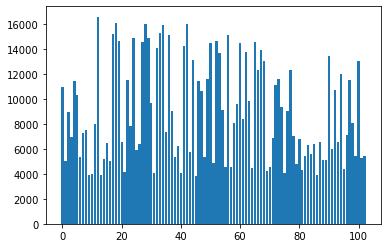

In [18]:
plt.bar(df_imgs_by_cl['cl'], df_imgs_by_cl['num_img'])
plt.show()

Классы не совсем хорошо сбалансированны\
от 4 до 16 тыс на класс\
для классов с количеством снимков до 5 тыс умножим количество на 3\
для классов с количеством снимков от 5 до 8 тыс умножим на 2\
просто копировать изображения не будем, сделаем аугментацию: добавление гаусовского шума и соль-перец шума

In [90]:
"""
Функции для создания шума
"""
import random
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 50
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy

def sp_noise(image,prob):
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

In [89]:
df_imgs=pd.read_csv('dataset.csv')
df_imgs = df_imgs.drop('Unnamed: 0', axis = 1)
df_imgs[['cl', 'num_car', 'num_img']] = df_imgs[['cl', 'num_car', 'num_img']].astype('int')
df_imgs.head(5)

car  cl  num_car  num_img
0  VAZ_2170_2007_2013   0        0      460
1  VAZ_2170_2007_2013   0        1      460
2  VAZ_2170_2007_2013   0        2      464
3  VAZ_2170_2007_2013   0        3      204
4  VAZ_2170_2007_2013   0        4      284

In [96]:
df_imgs.head(5)

car  cl  num_car  num_img
0  VAZ_2170_2007_2013   0        0      460
1  VAZ_2170_2007_2013   0        1      460
2  VAZ_2170_2007_2013   0        2      464
3  VAZ_2170_2007_2013   0        3      204
4  VAZ_2170_2007_2013   0        4      284

In [88]:
df_imgs_by_cl.head()

cl  num_img
0   0    10997
1   1     5017
2   2     8992
3   3     6940
4   4    11464

In [83]:
classes_less_5 = list(df_imgs_by_cl.loc[df_imgs_by_cl.num_img < 5000]['cl'])
classes_5_to_8 = list(df_imgs_by_cl.loc[(df_imgs_by_cl.num_img >5000) & (df_imgs_by_cl.num_img < 8000)]['cl'])

In [97]:
df_imgs_additional = pd.DataFrame({'car': [],'cl': [], 'num_car': [],'num_img':[] })
path = "D:\\data\\car_reco_imgs\\"
for i in classes_less_5:
    for index, row in df_imgs.loc[df_imgs['cl'] == i].iterrows():
        num_car  = row['num_car']
        num_img = row['num_img']
        for k in range(num_img+1):
            im = cv2.imread(path + str(i) + "_" + str(num_car) + "_" + str(k) + ".jpg")
            im_noise_gauss = noisy("gauss",im)
            im_noise_sp = sp_noise(im, 0.01)
            cv2.imwrite(path + str(i) + "_" + str(num_car) + "_" + str(k) + "_g" + ".jpg",im_noise_gauss)
            cv2.imwrite(path + str(i) + "_" + str(num_car) + "_" + str(k) + "_sp" + ".jpg",im_noise_sp)
        df_imgs_additional = df_imgs_additional\
        .append({'car': row['car'],'cl': i, 'num_car': num_car,'num_img':(num_img+1)*2}, ignore_index=True)

In [100]:
path = "D:\\data\\car_reco_imgs\\"
for i in classes_5_to_8:
    for index, row in df_imgs.loc[df_imgs['cl'] == i].iterrows():
        num_car  = row['num_car']
        num_img = row['num_img']
        for k in range(num_img+1):
            im = cv2.imread(path + str(i) + "_" + str(num_car) + "_" + str(k) + ".jpg")
            im_noise_sp = sp_noise(im, 0.01)
            cv2.imwrite(path + str(i) + "_" + str(num_car) + "_" + str(k) + "_sp" + ".jpg",im_noise_sp)
        df_imgs_additional = df_imgs_additional\
        .append({'car': row['car'],'cl': i, 'num_car': num_car,'num_img':(num_img+1)}, ignore_index=True)
        print ("ок : " + " номер класса: " + str(i) + " машина: " + str(num_car)+ " фоток: " + str(num_img+1))

ок :  номер класса: 1 машина: 0 фоток: 249
ок :  номер класса: 1 машина: 1 фоток: 293
ок :  номер класса: 1 машина: 2 фоток: 229
ок :  номер класса: 1 машина: 3 фоток: 373
ок :  номер класса: 1 машина: 4 фоток: 269
ок :  номер класса: 1 машина: 5 фоток: 445
ок :  номер класса: 1 машина: 6 фоток: 229
ок :  номер класса: 1 машина: 7 фоток: 229
ок :  номер класса: 1 машина: 8 фоток: 297
ок :  номер класса: 1 машина: 9 фоток: 269
ок :  номер класса: 1 машина: 10 фоток: -3
ок :  номер класса: 1 машина: 11 фоток: 229
ок :  номер класса: 1 машина: 12 фоток: 473
ок :  номер класса: 1 машина: 13 фоток: 361
ок :  номер класса: 1 машина: 14 фоток: 229
ок :  номер класса: 1 машина: 15 фоток: 389
ок :  номер класса: 1 машина: 16 фоток: 457
ок :  номер класса: 3 машина: 0 фоток: 305
ок :  номер класса: 3 машина: 1 фоток: 425
ок :  номер класса: 3 машина: 2 фоток: 461
ок :  номер класса: 3 машина: 3 фоток: 445
ок :  номер класса: 3 машина: 4 фоток: 437
ок :  номер класса: 3 машина: 5 фоток: 445
ок : 

In [ ]:
!python yolov5/detect.py --weights yolov5/weights/yolov5s.pt --img 640 --save-txt --nosave --conf 0.7 --source "D:/data/car_reco_imgs"

In [101]:
df_imgs_additional.to_csv('dataset_aug_and_balance_num_from_1.csv')

In [102]:
df_imgs_additional

car     cl  num_car  num_img
0     MITSUBISHI_LANCER_2000_2007    9.0      0.0    594.0
1     MITSUBISHI_LANCER_2000_2007    9.0      1.0    490.0
2     MITSUBISHI_LANCER_2000_2007    9.0      2.0    458.0
3     MITSUBISHI_LANCER_2000_2007    9.0      3.0    618.0
4     MITSUBISHI_LANCER_2000_2007    9.0      4.0    914.0
...                           ...    ...      ...      ...
1221             BMW_X3_2010_2014  102.0      9.0    473.0
1222             BMW_X3_2010_2014  102.0     10.0    473.0
1223             BMW_X3_2010_2014  102.0     11.0    361.0
1224             BMW_X3_2010_2014  102.0     12.0    437.0
1225             BMW_X3_2010_2014  102.0     13.0    245.0

[1226 rows x 4 columns]

Разметили все наши фото, теперь посчитаем их, разобьем на train, val и test

In [8]:
path = "runs/detect/exp4/labels"
filelist = []
for root, dirs, files in os.walk(path): 
    for file in files: #append the file name to the list 
        filelist.append(file)

In [11]:
df_imgs_labeled = pd.DataFrame({'im': [],'label': [], 'cl': [],'car':[],'n_img':[],'nose':[]})
i=0
for file in filelist:
    i=i+1
    label = file
    im = file.split('.')[0] + ".jpg"
    cl_car_im_nose = file.split('.')[0].split('_')
    cl = cl_car_im_nose[0]
    car = cl_car_im_nose[1]
    n_img = cl_car_im_nose[2]
    
    if len(cl_car_im_nose) == 4:
        nose = cl_car_im_nose[3 ]
    else:
        nose = ""
    df_imgs_labeled = df_imgs_labeled\
    .append({'im': im,'label': label, 'cl': cl,'car':car,'n_img':n_img,'nose':nose} , ignore_index=True)
    if i%10000 == 0:
        print ("ок : " + " file номер: " + str(i))
df_imgs_labeled.to_csv('df_imgs_labeled.csv')

ок :  file номер: 10000
ок :  file номер: 20000
ок :  file номер: 30000
ок :  file номер: 40000
ок :  file номер: 50000
ок :  file номер: 60000
ок :  file номер: 70000
ок :  file номер: 80000
ок :  file номер: 90000
ок :  file номер: 100000
ок :  file номер: 110000
ок :  file номер: 120000
ок :  file номер: 130000
ок :  file номер: 140000
ок :  file номер: 150000
ок :  file номер: 160000
ок :  file номер: 170000
ок :  file номер: 180000
ок :  file номер: 190000
ок :  file номер: 200000
ок :  file номер: 210000
ок :  file номер: 220000
ок :  file номер: 230000
ок :  file номер: 240000
ок :  file номер: 250000
ок :  file номер: 260000
ок :  file номер: 270000
ок :  file номер: 280000
ок :  file номер: 290000
ок :  file номер: 300000
ок :  file номер: 310000
ок :  file номер: 320000
ок :  file номер: 330000
ок :  file номер: 340000
ок :  file номер: 350000
ок :  file номер: 360000
ок :  file номер: 370000
ок :  file номер: 380000
ок :  file номер: 390000
ок :  file номер: 400000
ок :  fil

In [14]:
df_imgs_labeled.head(4)

im        label cl car n_img nose
0    0_0_0.jpg    0_0_0.txt  0   0     0     
1    0_0_1.jpg    0_0_1.txt  0   0     1     
2   0_0_10.jpg   0_0_10.txt  0   0    10     
3  0_0_100.jpg  0_0_100.txt  0   0   100

формат разметки: класс x_centre y_centre width height\
Поступим следующим образом: выберем на фото автомобиль(класс 2) который находится примерно по центру при этом,\
занимает максимальную площадь!\
данные разметки соберем в отдельные файлики

In [15]:
from sklearn.model_selection import train_test_split

In [21]:
path1 = "runs/detect/exp4/labels/"
filelist = []
my_string = ''

val,train = train_test_split(df_imgs_labeled, train_size=0.2, random_state=42)

log_data_labeling = pd.DataFrame({'class': [], 'label': [],'image':[], 'x':[],'y':[], 'width':[], 'height':[], 's':[]})

for index, row in val.iterrows():
    f = open(path1 + row[1], mode='r')
    my_string = f.read()
    s = 0.0
    max_sq_car = ''
    for obj in my_string.split('\n'):
        ob = obj.split(" ")
        if ob[0] == '2':
            width = float(ob[3])
            height = float(ob[4])
            if height*width > s:
                max_sq_car = obj
                s = height*width
    if s<0.2:
        continue
    else:
        shutil.copy("D:\\data\\car_reco_imgs\\" + row[0], 'D:\\data\\car_dataset\\val\images')
        my_car_label = open('D:\\data\\car_dataset\\val\\labels\\' + row[1], "w")
        my_car_label.write(row[2] + " " + max_sq_car[2:])
        my_car_label.close()
        max_sq_car_list = max_sq_car.split(" ")
        log_data_labeling = log_data_labeling.append({'class': row[2],
                                                      'label': row[1],
                                                      'image':row[0],
                                                      'x':float(max_sq_car_list[1]),
                                                      'y':float(max_sq_car_list[2]),
                                                      'width':float(max_sq_car_list[3]),
                                                      'height':float(max_sq_car_list[4]), 
                                                      's':s }, ignore_index=True)
    f.close()

In [22]:
for index, row in train.iterrows():
    f = open(path1 + row['label'], mode='r')
    my_string = f.read()
    s = 0.0
    max_sq_car = ''
    for obj in my_string.split('\n'):
        ob = obj.split(" ")
        if ob[0] == '2':
            width = float(ob[3])
            height = float(ob[4])
            if height*width > s:
                max_sq_car = obj
                s = height*width
    if s<0.2:
        continue
    else:
        shutil.copy("D:\\data\\car_reco_imgs\\" + row['im'], 'D:\\data\\car_dataset\\train\images')
        my_car_label = open('D:\\data\\car_dataset\\train\\labels\\' + row['label'], "w")
        my_car_label.write(row['cl'] + " " + max_sq_car[2:])
        my_car_label.close()
        max_sq_car_list = max_sq_car.split(" ")
        log_data_labeling = log_data_labeling.append({'class': row['cl'],
                                                      'label': row['label'],
                                                      'image':row['im'],
                                                      'x':float(max_sq_car_list[1]),
                                                      'y':float(max_sq_car_list[2]),
                                                      'width':float(max_sq_car_list[3]),
                                                      'height':float(max_sq_car_list[4]), 
                                                      's':s }, ignore_index=True)
    f.close()

In [10]:
len(filelist)

1085860

Дата сет на 1085860 фотографий для 103 классов готов!
### Обучение

In [ ]:
# Обучаем предобученные веса 5 эпох на наши данные
!python yolov5/train.py --img 416 --batch 8 --epochs 5 --data auto_rec_103.yaml --weights yolov5\weights\yolov5x.pt --workers 1 --device 0

<img src="results.png">
<img src="PR_curve.png">